<h1>Understanding QSP-Generated Quantum Circuit Scaling</h1>

<h2> Distribution Statement </h2>

DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

<br>
This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

<br>
© 2022 Massachusetts Institute of Technology.

<br>
<br>
The software/firmware is provided to you on an As-Is basis

<br>
<br>
Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

This notebook examines how the circuits generated by pyQSP scale.


In [1]:
### 
### Publicly Available Libraries:
###
import sys
import os
import time,datetime
import cirq
import matplotlib.pyplot as plt
import pandas as pd


###
### Imports to support the pyQSP Gate-Based simulation
###
from pyLIQTR.QSP import gen_qsp     as qspFuncs
from pyLIQTR.QSP import QSP         as pQSP
from pyLIQTR.QSP.Hamiltonian import Hamiltonian as pyH

from pyLIQTR.QSP.gen_qsp import QSP_Simulator
from pyLIQTR.QSP.qsp_helpers import qsp_decompose_once, print_to_openqasm, count_qubits

import pyLIQTR.sim_methods.quantum_ops as qops        
from pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform

<h2> Generate Hamiltonians to solve the TFIM problem of varying sizes </h2>

Note: Angle generation takes a lot of time. Since we aren't performing the actual circuit simulation, but only looking for a resource assessment, we use the "random" mode of compute_hamiltonian_angles to calculate the correct number of angles that would need to be used for this Hamiltonian, timestep, and precision (however, the values of the angles themselves are random)

In [2]:
###
### User Input: Vlasov Equation Parameterization 
###

#We note that increasing N will increase circuit size (both in terms of width and depth), since additional
#qubits are required to model the problem (width)
Ns     =  [4, 8, 16, 32 ]#, 64, 128]           # Number of terms in the problem
                                               # (equivalent to qubits)

J_z  =   1.0;          
h_x  =  -1.0

# QSP specification
#Increasing the precision or increasing the sim time are likely to increase circuit depth, since additional QSP
#terms may be introduced
timestep_of_interest = 0.05
required_precision   = 1e-4



ham_strings = []
qsp_hams    = []
steps       = []
angles      = []
for N_ in Ns:
    ###
    tuples,types,coeffs = qops.params_heisenberg_1d(N_,J_z=J_z,h_x=h_x,periodic=False)
    N    =   4;        J_z  =   1.0;          h_x  =  -1.0
    tuples,types,coeffs = qops.params_heisenberg_1d(N,J_z=J_z,h_x=h_x,periodic=False)
    hs = qops.ps_text_full_set(tuples,types,N_,Coeffs=coeffs)

    curr_qsp_H = pyH(hs)
    
    qsp_hams.append(curr_qsp_H)
    ham_strings.append(hs)
    print("Start computing angles for {}:{}".format(N_,datetime.datetime.now()))
    angles.append(qspFuncs.compute_hamiltonian_angles(curr_qsp_H, timestep_of_interest, required_precision, mode="random")[0])
    print("\tFinish computing angles for {}:{}".format(N_,datetime.datetime.now()))
 

Start computing angles for 4:2023-03-01 14:09:07.027487
	Finish computing angles for 4:2023-03-01 14:09:07.029977
Start computing angles for 8:2023-03-01 14:09:07.030031
	Finish computing angles for 8:2023-03-01 14:09:07.032015
Start computing angles for 16:2023-03-01 14:09:07.032089
	Finish computing angles for 16:2023-03-01 14:09:07.034046
Start computing angles for 32:2023-03-01 14:09:07.034129
	Finish computing angles for 32:2023-03-01 14:09:07.036014


<h2> Generate the circuits </h2>

In [3]:
###
### A function to generate the circuit scaling statistics. Left in the notebook
### to enable future customizability.
###

def generate_circuit_stats(ham, angs, csv_out='scaling_data.csv', save_circuit=False):

    t_start_time = time.time()

    # Generate circuit:
    qsp_generator   = pQSP.QSP(phis=angs, hamiltonian=ham, target_size=ham.problem_size)
    curr_circ       = qsp_generator.circuit()
    t_initial_generation_time = time.time()

    # Decompose circuit:
    decomposed_circuit       = cirq.align_left(qsp_decompose_once(qsp_decompose_once(curr_circ)))
    t_decomp_to_toffoli_time = time.time()

    cliffT_decomp_circuit   = cirq.align_left(clifford_plus_t_direct_transform(decomposed_circuit))
    t_decomp_to_cliffT_time = time.time()

    if save_circuit:
        # Save circuit to file in OpenQASM 2.0 format:
        with open(f'open_qasm_for_problem_size_{H.problem_size}_toffoli.qasm', 'w') as f:
            print_to_openqasm(f, decomposed_circuit)
        t_write_toffoli_time = time.time()
        
        with open(f'open_qasm_for_problem_size_{H.problem_size}_cliffT.qasm', 'w') as f:
            print_to_openqasm(f, cliffT_decomp_circuit)
        t_write_cliffT_time = time.time()


    # Lets write all this stuff out:
    if os.path.exists(csv_out):
        yes_header = False
    else:
        yes_header = True
    out_file = open(csv_out, 'a')
    if yes_header:
        out_file.write('Prob_Size,Circ_Gen_Time,Toff_Decomp_Time,CliffT_Decomp_Time,Write_Out_Toff_Time,Write_Out_CliffT_Time,Ttl_Qubits,Anc_Qubits,Ctl_Qubits,Circ_Depth_Toff,Circ_Depth_cliffT\n')

    # Calculate the times
    t_gen    = (t_initial_generation_time - t_start_time)
    t_toff   = (t_decomp_to_toffoli_time  - t_initial_generation_time)
    t_clifft = (t_decomp_to_cliffT_time   - t_decomp_to_toffoli_time)
    if save_circuit:
        t_write_out_toff   = (t_write_toffoli_time - t_decomp_to_cliffT_time)
        t_write_out_cliffT = (t_write_cliffT_time  - t_write_toffoli_time)
    else:
        t_write_out_toff   = -1
        t_write_out_cliffT = -1

    print_string = f'{ham.problem_size},{t_gen},{t_toff},{t_clifft},{t_write_out_toff},{t_write_out_cliffT}'

    ttl_qubits, ctl_qubits, anc_qubits = count_qubits(curr_circ)

    print_string += f',{ttl_qubits},{anc_qubits},{ctl_qubits}'


    depth_toff   = len(cirq.align_left(decomposed_circuit))
    depth_cliffT = len(cirq.align_left(cliffT_decomp_circuit))

    print_string += f',{depth_toff},{depth_cliffT}\n'

    out_file.write(print_string)

In [4]:
os.remove('scaling_data.csv')
for H, angs in zip(qsp_hams, angles):
    print("Start generating @ {}".format(datetime.datetime.now()))
    generate_circuit_stats(H, angs)
    print("\tFinish generating @ {}".format(datetime.datetime.now()))

data = pd.read_csv('scaling_data.csv')

Start generating @ 2023-03-01 14:09:07.064775
	Finish generating @ 2023-03-01 14:09:08.692085
Start generating @ 2023-03-01 14:09:08.692210
	Finish generating @ 2023-03-01 14:09:10.720579
Start generating @ 2023-03-01 14:09:10.720717
	Finish generating @ 2023-03-01 14:09:12.434872
Start generating @ 2023-03-01 14:09:12.435037
	Finish generating @ 2023-03-01 14:09:14.213886


<h2> Analyze and plot some parameters of interest </h2>

In [5]:
data

,Prob_Size,Circ_Gen_Time,Toff_Decomp_Time,CliffT_Decomp_Time,Write_Out_Toff_Time,Write_Out_CliffT_Time,Ttl_Qubits,Anc_Qubits,Ctl_Qubits,Circ_Depth_Toff,Circ_Depth_cliffT
0,4,0.002379,0.064859,1.117523,-1,-1,11,3,3,383,15310
1,8,0.001464,0.069720,1.530579,-1,-1,15,3,3,383,15308
2,16,0.001558,0.058915,1.185362,-1,-1,23,3,3,383,15233
3,32,0.003408,0.074976,1.273076,-1,-1,39,3,3,383,15247


Text(0, 0.5, 'Time [msec]')

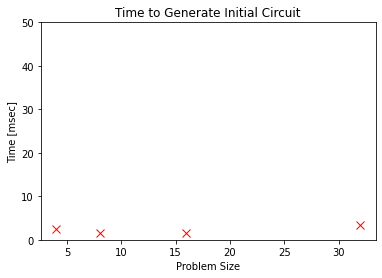

In [6]:
###
### Timing:
###


# plt.figure(figsize=(10/2,7.5/2), dpi=300)

plt.plot(data['Prob_Size'], data['Circ_Gen_Time']*1000, 'rx', markersize=8)
plt.ylim([0, 50])
plt.title('Time to Generate Initial Circuit')
plt.xlabel('Problem Size')
plt.ylabel('Time [msec]')

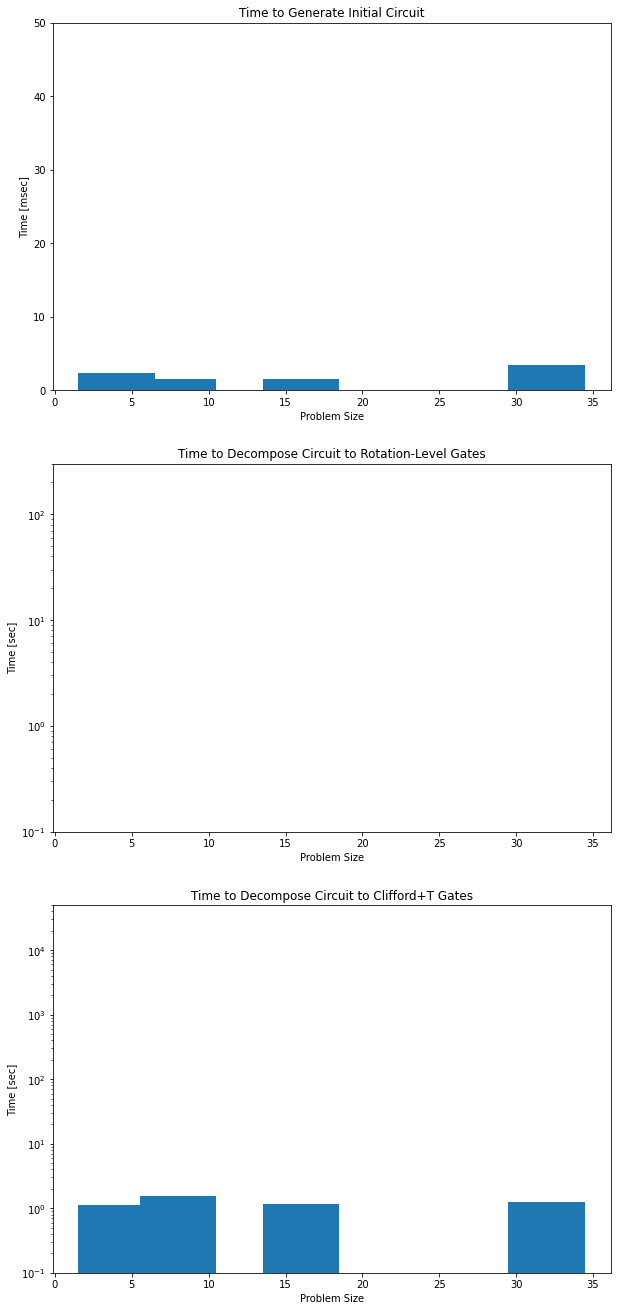

In [7]:
###
### Timing:
###

fig_time, ax_time = plt.subplots(3)
fig_time.set_figheight(23)
fig_time.set_figwidth(10)

ax_time[0].bar(data['Prob_Size'], data['Circ_Gen_Time']*1000, width=5)
ax_time[0].set_ylim([0, 50])
ax_time[0].set_title('Time to Generate Initial Circuit')
ax_time[0].set_xlabel('Problem Size')
ax_time[0].set_ylabel('Time [msec]')

ax_time[1].bar(data['Prob_Size'], data['Toff_Decomp_Time'], width=5)
ax_time[1].set_ylim([0.1, 300])
ax_time[1].set_title('Time to Decompose Circuit to Rotation-Level Gates')
ax_time[1].set_xlabel('Problem Size')
ax_time[1].set_ylabel('Time [sec]')
ax_time[1].set_yscale('log')

ax_time[2].bar(data['Prob_Size'], data['CliffT_Decomp_Time'], width=5)
ax_time[2].set_ylim([0.1, 50000])
ax_time[2].set_title('Time to Decompose Circuit to Clifford+T Gates')
ax_time[2].set_xlabel('Problem Size')
ax_time[2].set_ylabel('Time [sec]')
ax_time[2].set_yscale('log')


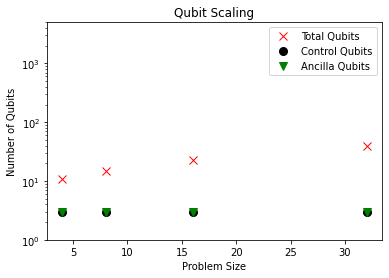

In [8]:
###
### Number of Qubits:
###
# plt.figure(figsize=(10/2,7.5/2), dpi=200)
plt.plot(data['Prob_Size'], data['Ttl_Qubits'], 'rx', markersize=8)
plt.plot(data['Prob_Size'], data['Ctl_Qubits'], 'ko', markersize=8)
plt.plot(data['Prob_Size'], data['Anc_Qubits'], 'gv', markersize=8)
plt.title('Qubit Scaling')
plt.xlabel('Problem Size')
plt.ylim([1, 5000])
plt.ylabel('Number of Qubits')
plt.yscale('log')
plt.legend([
    'Total Qubits',
    'Control Qubits',
    'Ancilla Qubits'
])

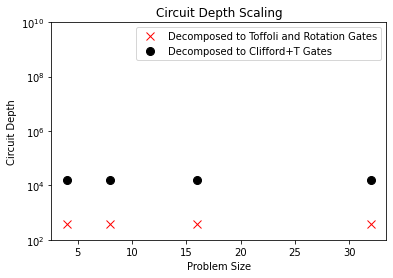

In [9]:
###
### Circuit Depth:
###

# plt.figure(figsize=(10/2,7.5/2), dpi=300)

plt.plot(data['Prob_Size'], data['Circ_Depth_Toff'], 'rx', markersize=8)
plt.plot(data['Prob_Size'], data['Circ_Depth_cliffT'], 'ko', markersize=8)
plt.yscale('log')
plt.ylim([10e1, 10e9])
plt.xlabel('Problem Size')
plt.ylabel('Circuit Depth')
plt.title('Circuit Depth Scaling')

plt.legend([
    'Decomposed to Toffoli and Rotation Gates',
    'Decomposed to Clifford+T Gates',
])